In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import statistics

In [2]:
G= nx.read_edgelist('edgelist.txt')

/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


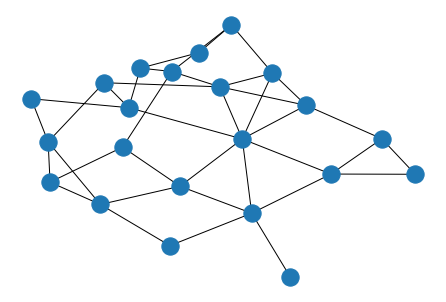

In [3]:
nx.draw(G);

In [4]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 22
Number of edges: 38
Average degree:   3.4545


Below is the process that takes graph G and returns lists 'sortedpost1' and 'sortedpost2', lists of nodes in the supposedly-optimal partitions. I print the actions of each turn to check it against my manual partitioning.

In [5]:
# ALGORITHM
fromTen = np.empty((0, 2), str)
fromTwenty = np.empty((0, 2), str)
for v in G:
    distTen = nx.dijkstra_path_length(G, v, '10')
    distTwenty = nx.dijkstra_path_length(G,v,'20')
    
    stackableTen = np.array([v,distTen])
    stackableTwenty = np.array([v,distTwenty])
    
    fromTwenty = np.vstack((fromTwenty, stackableTwenty))
    fromTen = np.vstack((fromTen,stackableTen))

df1 = pd.DataFrame(fromTen)
df1.columns = ['weight','distance']
df2 = pd.DataFrame(fromTwenty)
df2.columns = ['weight','distance']

cols = ['distance', 'weight']
df1[cols] = df1[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df2[cols] = df2[cols].apply(pd.to_numeric, errors='coerce', axis=1)
sorteddf1 = df1.sort_values(['distance', 'weight'], ascending = [1,0])
sorteddf2 = df2.sort_values(['distance', 'weight'], ascending = [1,0])

sortedpre1 = sorteddf1['weight'].to_numpy()
sortedpre2 = sorteddf2['weight'].to_numpy()

sortedpost1 =  np.empty((0, 1), int)
sortedpost2 =  np.empty((0, 1), int)

unavailable = np.empty((0,1),int)

vol1 = 0
vol2 = 0

while (vol1+vol2)<231:
    vol1 = np.sum(sortedpost1.astype(np.float))
    vol2 = np.sum(sortedpost2.astype(np.float))
    
    if vol1<vol2: #1 takes
        if sortedpre1[0] not in unavailable:
            sortedpost1 = np.append(sortedpost1, sortedpre1[0])
            print(sortedpre1[0],'taken by Red')
        unavailable = np.append(unavailable,sortedpre1[0])
        sortedpre1 = np.delete(sortedpre1,0)
    else:
        if sortedpre2[0] not in unavailable:
            sortedpost2 = np.append(sortedpost2, sortedpre2[0])
            print(sortedpre2[0],'taken by Blue')
        unavailable = np.append(unavailable,sortedpre2[0])
        sortedpre2 = np.delete(sortedpre2,0,)

20 taken by Blue
10 taken by Red
11 taken by Red
19 taken by Blue
1 taken by Red
12 taken by Red
3 taken by Red
0 taken by Red
16 taken by Red
8 taken by Blue
21 taken by Blue
13 taken by Red
7 taken by Red
18 taken by Blue
5 taken by Red
4 taken by Red
2 taken by Red
17 taken by Red
9 taken by Blue
6 taken by Blue
15 taken by Blue
14 taken by Red


In [6]:
#make subgraphs
subset1 = list(map(str, sortedpost1))
subset2 = list(map(str, sortedpost2))
subg1 = G.subgraph(subset1)
subg2 = G.subgraph(subset2)

In [7]:
print(nx.info(subg1))
print(nx.info(subg2))

Name: 
Type: Graph
Number of nodes: 14
Number of edges: 21
Average degree:   3.0000
Name: 
Type: Graph
Number of nodes: 8
Number of edges: 8
Average degree:   2.0000


Now we can calulate impedance . . .

In [8]:
def calcImpedance(listA, listB):
    #take the partition lists, build dfs on dijkstra, multiply dist*id
    nodeFrame1 = pd.DataFrame(np.array(listA).astype(int),columns = ['node'])
    nodeFrame1['dist'] = nodeFrame1['node'].apply(lambda x: nx.dijkstra_path_length(G,'10',str(x)))
    nodeFrame1['imped'] = nodeFrame1['node']*nodeFrame1['dist']
    
    nodeFrame2 = pd.DataFrame(np.array(listB).astype(int),columns = ['node'])
    nodeFrame2['dist'] = nodeFrame2['node'].apply(lambda x: nx.dijkstra_path_length(G,'20',str(x)))
    nodeFrame2['imped'] = nodeFrame2['node']*nodeFrame2['dist']
    
    treeW1 = nodeFrame1['imped'].sum()
    treeW2 = nodeFrame2['imped'].sum()

    impedance = treeW1 + treeW2
    return impedance
calcImpedance(sortedpost1,sortedpost2)

487

. . . and disparity.

In [10]:
def calcDisparity(listA,listB):
    vol1 = np.sum(listA.astype(np.float))
    vol2 = np.sum(listB.astype(np.float))
    expec_vol = 231/2
    disparity = .5*(np.abs(vol1-expec_vol)) + (np.abs(vol2-expec_vol))
    return disparity
calcDisparity(sortedpost1,sortedpost2)

0.75

Below is the search for counterexamples. We randomly partition G and print any better metrics from only the contiguous node lists. This is promising but not extensive.

In [11]:
def makeRandomG(G):
    list_in = list(G.nodes())
    list1 = random.sample(list_in, random.randint(0,22))
    list2 = [item for item in list_in if item not in list1]
    return list1, list2

In [14]:
def main():
    for i in range(10000):
        randy = makeRandomG(G)
        imped = calcImpedance(np.array(randy[0]),np.array(randy[1]))

        disp = calcDisparity(np.array(randy[0]),np.array(randy[1]))
        
        #Here we could insert whatever function counts exclusions
        
        results = pd.DataFrame(columns=['imped','disp'])
        if(imped<500):
            if(disp<1):
                print(imped,disp)
main()